<a href="https://colab.research.google.com/github/davidhasbany/hello-world/blob/master/dm_app_forecast_08_02_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from fbprophet import Prophet

# Authenticate
from google.colab import auth
auth.authenticate_user()
project_id = 'data-lake-prod-223818'

In [0]:
# import bigquery
from google.cloud import bigquery
# get client via project id
bq = bigquery.Client(project=project_id)
query = """
    SELECT CAST(SignalDateTime AS DATE) AS ds
    , IsPriorBorrower AS ExistingCustomer
    , COUNT(*) AS y
    FROM DW.fact_borrower_event_application
    WHERE MarketingLastTouchChannelName = 'Direct Mail'
      AND CAST(SignalDateTime AS DATE) BETWEEN CAST('2017-01-01' AS DATE) AND CAST('2019-05-31' AS DATE)
      AND CAST(SignalDateTime AS DATE) < CAST(CURRENT_DATE("America/Los_Angeles") AS DATE)
    GROUP BY 1,2
    ORDER BY 1,2
  """
# output query to pandas dataframe
df = bq.query(query).to_dataframe()

In [0]:
df.head()

,ds,ExistingCustomer,y
0,2017-01-01,False,1069
1,2017-01-01,True,13
2,2017-01-02,False,1888
3,2017-01-02,True,16
4,2017-01-03,False,2388


In [0]:
#df[['year','month','day']] = df.ds.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))

In [0]:
#df[['year','month','y']].groupby(['year','month']).sum()

In [0]:
df_ec = df[df['ExistingCustomer'] == True].iloc[:,[0,2]]
df_nc = df[df['ExistingCustomer'] == False].iloc[:,[0,2]]

In [0]:
df_ec.head()

,ds,y
1,2017-01-01,13
3,2017-01-02,16
5,2017-01-03,30
7,2017-01-04,33
9,2017-01-05,36


In [0]:
m = Prophet() #yearly_seasonality=False,daily_seasonality=False,changepoints=['2017-02-01','2017-10-01','2019-01-01']
m.fit(df_nc)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=240)
future.tail()

,ds
1116,2020-01-22
1117,2020-01-23
1118,2020-01-24
1119,2020-01-25
1120,2020-01-26


In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1116,2020-01-22,670.693228,-119.301060,1458.188351
1117,2020-01-23,595.965402,-162.759254,1396.865290
1118,2020-01-24,362.406833,-408.300524,1128.688505
1119,2020-01-25,28.748631,-750.646411,865.726867
1120,2020-01-26,-251.350135,-1024.166486,580.587667


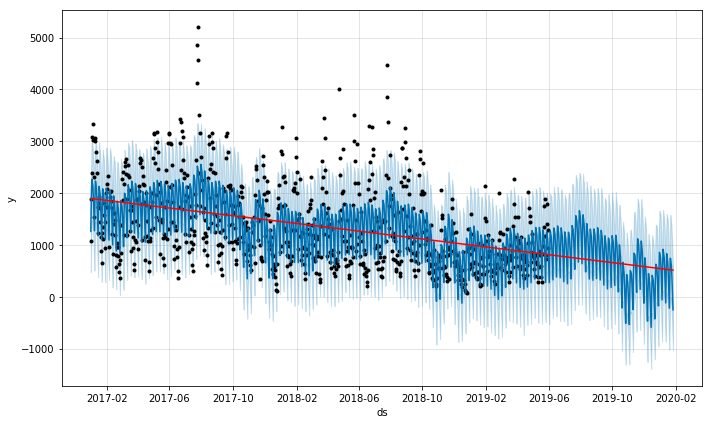

In [0]:
from fbprophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

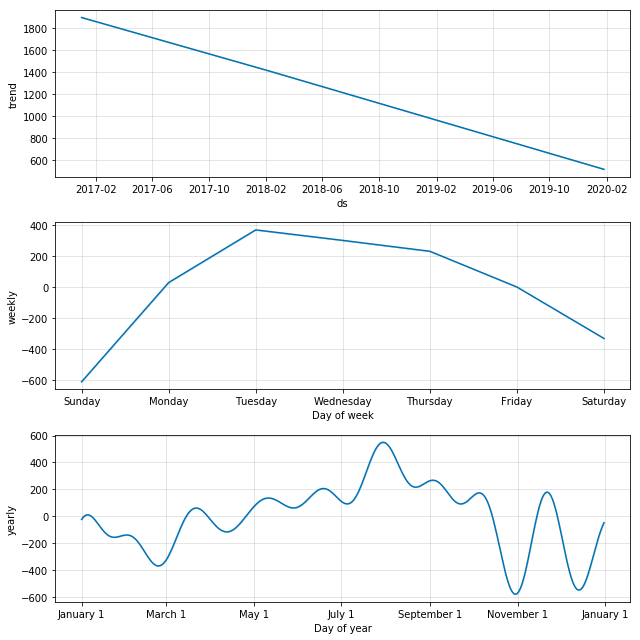

In [0]:
fig2 = m.plot_components(forecast)

In [0]:
forecast.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.0,1121.0,1121.0,1121.000000
mean,1209.639464,424.891857,1990.977176,1209.564117,1209.718946,-2.156877,-2.156877,-2.156877,-0.544195,-0.544195,-0.544195,-1.612682,-1.612682,-1.612682,0.0,0.0,0.0,1207.482587
std,400.157268,580.584898,579.222675,400.272846,400.035248,412.889828,412.889828,412.889828,331.264887,331.264887,331.264887,246.123924,246.123924,246.123924,0.0,0.0,0.0,578.193154
min,514.196532,-1386.102936,232.853218,513.267323,515.149420,-1184.837717,-1184.837717,-1184.837717,-610.042984,-610.042984,-610.042984,-580.602306,-580.602306,-580.602306,0.0,0.0,0.0,-590.282486
25%,863.170370,32.086037,1598.522660,863.170370,863.170370,-284.496734,-284.496734,-284.496734,-330.103774,-330.103774,-330.103774,-146.706533,-146.706533,-146.706533,0.0,0.0,0.0,821.649085
50%,1212.144220,440.969341,2009.095406,1212.144220,1212.144220,67.758081,67.758081,67.758081,30.964912,30.964912,30.964912,43.368284,43.368284,43.368284,0.0,0.0,0.0,1231.538444
75%,1557.256923,853.203173,2427.539673,1557.256923,1557.256923,309.248237,309.248237,309.248237,303.176779,303.176779,303.176779,154.104810,154.104810,154.104810,0.0,0.0,0.0,1643.615694
max,1895.396884,1788.029087,3348.168307,1895.396884,1895.396884,920.607381,920.607381,920.607381,370.925980,370.925980,370.925980,550.389677,550.389677,550.389677,0.0,0.0,0.0,2554.048177


In [0]:
# from google.colab import files
# forecast.to_csv('fbprophet_forecast.csv') 
# files.download('fbprophet_forecast.csv')

In [0]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,1895.396884,479.913715,2077.550936,1895.396884,1895.396884,-633.800475,-633.800475,-633.800475,-610.042984,-610.042984,-610.042984,-23.757491,-23.757491,-23.757491,0.0,0.0,0.0,1261.596409
1,2017-01-02,1894.189243,1101.921847,2751.828920,1894.189243,1894.189243,22.001954,22.001954,22.001954,30.964912,30.964912,30.964912,-8.962958,-8.962958,-8.962958,0.0,0.0,0.0,1916.191197
2,2017-01-03,1892.981601,1472.039962,3065.219171,1892.981601,1892.981601,372.575143,372.575143,372.575143,370.925980,370.925980,370.925980,1.649163,1.649163,1.649163,0.0,0.0,0.0,2265.556744
3,2017-01-04,1891.773960,1388.494462,2957.297655,1891.773960,1891.773960,311.341625,311.341625,311.341625,303.176779,303.176779,303.176779,8.164846,8.164846,8.164846,0.0,0.0,0.0,2203.115585
4,2017-01-05,1890.566319,1326.070093,2826.441460,1890.566319,1890.566319,243.669675,243.669675,243.669675,232.904181,232.904181,232.904181,10.765494,10.765494,10.765494,0.0,0.0,0.0,2134.235994


In [0]:
forecast[(forecast['ds'] >= '2019-06-01') & (forecast['ds'] < '2019-07-01')].sum()['trend_lower']

23819.68531651399

In [0]:
forecast[['year','month','day']] = forecast.ds.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))

In [0]:
forecast[['year','month','trend']].groupby(['year','month']).sum()

trend
year month              
2017 01     58195.750212
     02     51566.391661
     03     55986.974172
     04     53075.950890
     05     53703.324368
     06     50865.967319
     07     51419.674693
     08     50259.131293
     09     47532.874404
     10     47975.466018
     11     45322.863700
     12     45691.561251
2018 01     44519.934367
     02     39189.498895
     03     42250.937159
     04     39748.088576
     05     39894.654273
     06     37467.333381
     07     37537.834429
     08     36340.106193
     09     34027.447955
     10     33983.286326
     11     31746.654596
     12     31626.466511
2019 01     30428.738444
     02     26454.548997
     03     28149.191479
     04     26100.756394
     05     25792.371735
     06     23819.963094
     07     23435.551991
     08     22237.823925
     09     20380.078116
     10     19881.004181
     11     18099.284816
     12     17524.184438
2020 01     13774.168740

In [0]:
df_nc[(df_nc['ds'] >= pd.to_datetime('2019-05-01').date()) & (df_nc['ds'] < pd.to_datetime('2019-06-01').date())].sum()['y']

26842